### Predicting Solana Price with Python and Machine Learning using XGBoost

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Load the dataset
data = pd.read_csv('solana_2020-04-09_2024-10-26.csv')
data['Start'] = pd.to_datetime(data['Start'])
data.set_index('Start', inplace=True)

# Feature Engineering: Adding lagged features and rolling statistics
target = 'Close'
lags = [1, 7, 14, 30]
for lag in lags:
    data[f'{target}_lag_{lag}'] = data[target].shift(lag)



In [27]:
# Rolling statistics
data['rolling_mean_7'] = data[target].rolling(window=7).mean()
data['rolling_std_7'] = data[target].rolling(window=7).std()
data['rolling_mean_30'] = data[target].rolling(window=30).mean()
data['rolling_std_30'] = data[target].rolling(window=30).std()

# Drop NaN values created by lagging and rolling windows
data.dropna(inplace=True)


In [28]:
data.head()

,End,Open,High,Low,Close,Volume,Market Cap,Close_lag_1,Close_lag_7,Close_lag_14,Close_lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
Start,,,,,,,,,,,,,,,
2024-09-25,2024-09-26,117.681598,118.596919,113.874834,114.408591,1.075554e+10,5.453394e+10,119.982404,108.498673,107.628423,126.569321,118.590105,3.915060,117.566697,7.825675
2024-09-24,2024-09-25,111.811425,118.501605,110.721066,117.921387,9.492087e+09,5.317877e+10,114.408591,112.322261,110.773547,136.186059,119.389981,2.847481,116.957874,6.993395
2024-09-23,2024-09-24,111.339873,114.880761,110.258698,111.945714,8.944457e+09,5.235648e+10,117.921387,117.856404,111.392276,131.823928,118.545596,4.015039,116.295267,6.457475
2024-09-22,2024-09-23,115.528509,115.621816,109.194888,111.822539,6.023014e+09,5.269417e+10,111.945714,122.491125,113.020483,129.073411,117.021513,4.283607,115.720238,6.034599
2024-09-21,2024-09-22,113.010064,115.569182,111.756938,115.569182,9.056881e+09,5.324689e+10,111.822539,121.255750,110.219646,128.770645,116.209146,3.865588,115.280189,5.508537


In [29]:

target_column = 'Close'
X = data.drop(columns=[target_column])
y = data[target_column]

print("Data types before processing:")
print(X.dtypes)

X = X.copy()  # Create a copy to avoid warnings
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X[col] = X[col].astype('category')

# Modify the XGBoost model to handle categorical variables
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    enable_categorical=True  # Enable categorical feature support
)

Data types before processing:
End                 object
Open               float64
High               float64
Low                float64
Volume             float64
Market Cap         float64
Close_lag_1        float64
Close_lag_7        float64
Close_lag_14       float64
Close_lag_30       float64
rolling_mean_7     float64
rolling_std_7      float64
rolling_mean_30    float64
rolling_std_30     float64
dtype: object


In [30]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

param_grid = {
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [6, 8, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust n_splits as needed

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    enable_categorical=True  # Enable categorical feature support if using categorical features
)

# Hyperparameter tuning with RandomizedSearchCV and TimeSeriesSplit
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)
# Fit the model
random_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=Non...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.005, 0.01, 0.05],
                                        'max_depth': [6, 8, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [1000, 2000, 3000],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='neg_mean_squared_error', verbose=1)

In [31]:
# Get the best model from the search
best_xgb_model = random_search.best_estimator_

# Make predictions on the entire dataset for visualization purposes
y_pred = best_xgb_model.predict(X)

# Evaluate the model on the entire dataset
final_rmse = np.sqrt(mean_squared_error(y, y_pred))
final_mae = mean_absolute_error(y, y_pred)
print(f'Final RMSE: {final_rmse}, Final MAE: {final_mae}')





Final RMSE: 0.0008485684606789772, Final MAE: 0.0005788799367891521


In [32]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y, y_pred)

# Convert to percentage
r2_percentage = r2 * 100

# Print all metrics including R-squared
print(f'Final RMSE: {final_rmse:.4f}')
print(f'Final MAE: {final_mae:.4f}')
print(f'R-squared: {r2:.4f}')
print(f'R-squared Percentage: {r2_percentage:.2f}%')

# You can also get the R-squared from cross-validation results
cv_r2 = random_search.best_score_  # This will be negative MSE from your current scoring
print(f'Cross-validation R-squared: {cv_r2:.4f}')

# Optional: Create a dictionary of all metrics
metrics = {
    'RMSE': final_rmse,
    'MAE': final_mae,
    'R-squared': r2,
    'R-squared Percentage': r2_percentage,
    'Cross-validation Score': cv_r2
}

# Print detailed metrics
print("\nDetailed Model Performance Metrics:")
for metric, value in metrics.items():
    if metric == 'R-squared Percentage':
        print(f'{metric}: {value:.2f}%')
    else:
        print(f'{metric}: {value:.4f}')

Final RMSE: 0.0008
Final MAE: 0.0006
R-squared: 1.0000
R-squared Percentage: 100.00%
Cross-validation R-squared: -427.5095

Detailed Model Performance Metrics:
RMSE: 0.0008
MAE: 0.0006
R-squared: 1.0000
R-squared Percentage: 100.00%
Cross-validation Score: -427.5095


In [33]:
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])

Number of samples: 1631
Number of features: 14


In [34]:
# Print feature names
print("Feature columns:", list(X.columns))

# Check for time-related columns
time_related = [col for col in X.columns if any(t in col.lower() 
            for t in ['time', 'date', 'year', 'month', 'day'])]
print("Time-related columns:", time_related)

# Print first few rows of your data
print("\nFirst few rows of features:")
print(X.head())
print("\nFirst few rows of target:")
print(y.head())

Feature columns: ['End', 'Open', 'High', 'Low', 'Volume', 'Market Cap', 'Close_lag_1', 'Close_lag_7', 'Close_lag_14', 'Close_lag_30', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'rolling_std_30']
Time-related columns: []

First few rows of features:
                   End        Open        High         Low        Volume  \
Start                                                                      
2024-09-25  2024-09-26  117.681598  118.596919  113.874834  1.075554e+10   
2024-09-24  2024-09-25  111.811425  118.501605  110.721066  9.492087e+09   
2024-09-23  2024-09-24  111.339873  114.880761  110.258698  8.944457e+09   
2024-09-22  2024-09-23  115.528509  115.621816  109.194888  6.023014e+09   
2024-09-21  2024-09-22  113.010064  115.569182  111.756938  9.056881e+09   

              Market Cap  Close_lag_1  Close_lag_7  Close_lag_14  \
Start                                                              
2024-09-25  5.453394e+10   119.982404   108.498673    107.628423   
202

In [35]:
# Check target variable distribution
print("\nTarget variable statistics:")
print(y.describe())

# Ensure X and y only contain numeric data for correlation calculation
X_numeric = X.select_dtypes(include=[np.number])
y_numeric = pd.to_numeric(y, errors='coerce')  # Convert y to numeric, handling errors if needed

# Check for high correlation with the target variable
correlations = X_numeric.corrwith(y_numeric)
high_corr = correlations[abs(correlations) > 0.95]

if not high_corr.empty:
    print("\nFeatures with very high correlation to the target variable:")
    print(high_corr)
else:
    print("\nNo features with very high correlation to the target variable.")



Target variable statistics:
count    1631.000000
mean       47.231234
std        47.885055
min         0.402667
25%        11.563630
50%        25.090297
75%        80.270494
max       199.609496
Name: Close, dtype: float64

Features with very high correlation to the target variable:
Open               0.997332
High               0.998934
Low                0.998580
Market Cap         0.966699
Close_lag_1        0.997309
Close_lag_7        0.979588
Close_lag_14       0.958120
rolling_mean_7     0.994652
rolling_mean_30    0.969944
dtype: float64


In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# Define scoring functions for MAE, MSE, and RMSE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)

# Perform cross-validation for each metric
mae_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=mae_scorer)
mse_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=mse_scorer)
rmse_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=rmse_scorer)

# Print the cross-validation results
print("\nCross-validation Mean Absolute Error (MAE):", -mae_scores.mean())
print("Mean CV MAE:", -mae_scores.mean())
print("CV MAE std:", mae_scores.std())

print("\nCross-validation Mean Squared Error (MSE):", -mse_scores.mean())
print("Mean CV MSE:", -mse_scores.mean())
print("CV MSE std:", mse_scores.std())

print("\nCross-validation Root Mean Squared Error (RMSE):", -rmse_scores.mean())
print("Mean CV RMSE:", -rmse_scores.mean())
print("CV RMSE std:", rmse_scores.std())



Cross-validation Mean Absolute Error (MAE): 17.295821363993603
Mean CV MAE: 17.295821363993603
CV MAE std: 14.351997754625927

Cross-validation Mean Squared Error (MSE): 612.973878086314
Mean CV MSE: 612.973878086314
CV MSE std: 833.162414660393

Cross-validation Root Mean Squared Error (RMSE): 19.842024743104556
Mean CV RMSE: 19.842024743104556
CV RMSE std: 14.80769840928497


In [37]:
# More robust evaluation
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_test_pred = xgb_model.predict(X_test)

# Calculate metrics on test set
test_r2 = r2_score(y_test, y_test_pred)
print(f"\nTest set R²: {test_r2:.4f} ({test_r2*100:.2f}%)")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))


Test set R²: 0.9336 (93.36%)

Top 10 most important features:
           feature    importance
2             High  6.708948e-01
3              Low  2.037661e-01
1             Open  8.850732e-02
6      Close_lag_1  3.477004e-02
0              End  1.975810e-03
10  rolling_mean_7  6.794140e-05
4           Volume  1.780024e-05
5       Market Cap  2.069060e-07
7      Close_lag_7  0.000000e+00
8     Close_lag_14  0.000000e+00


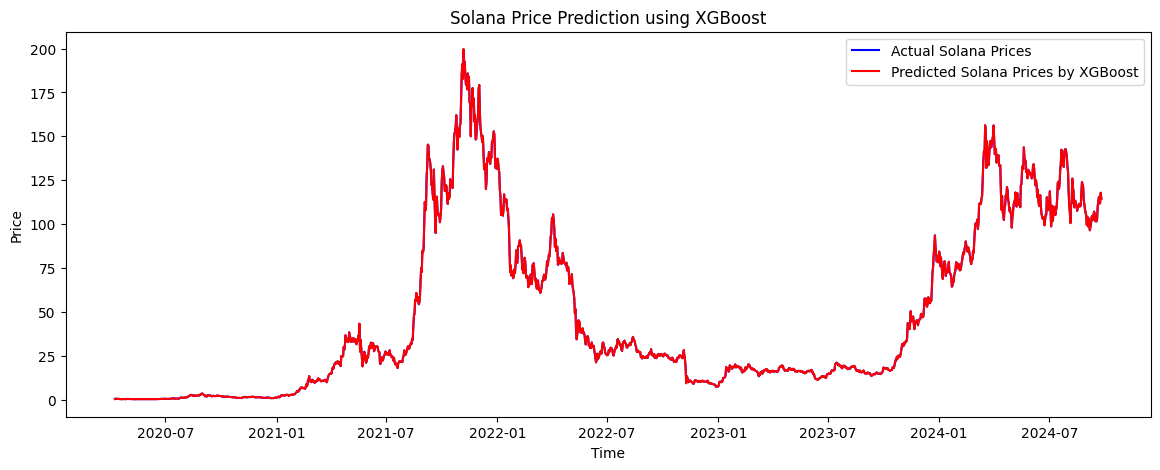

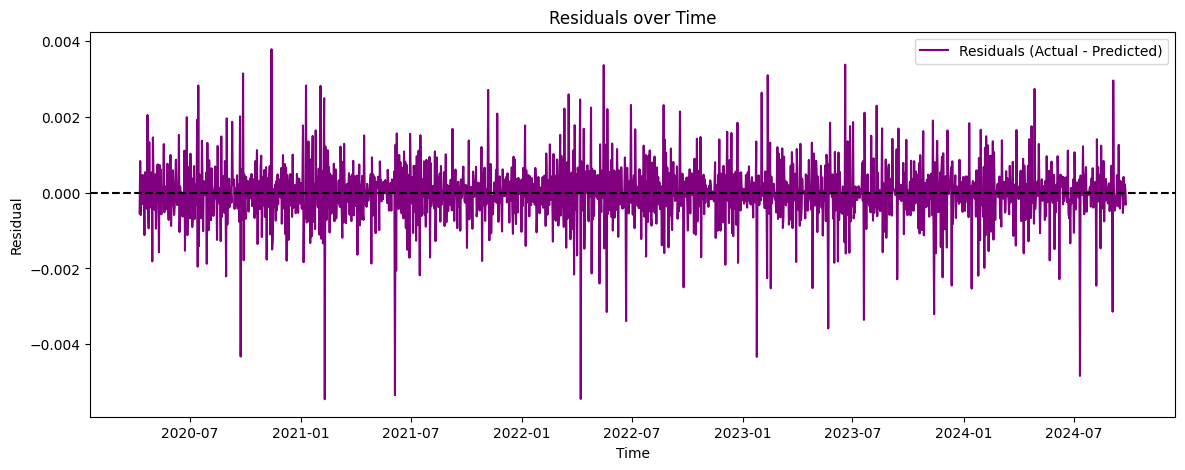

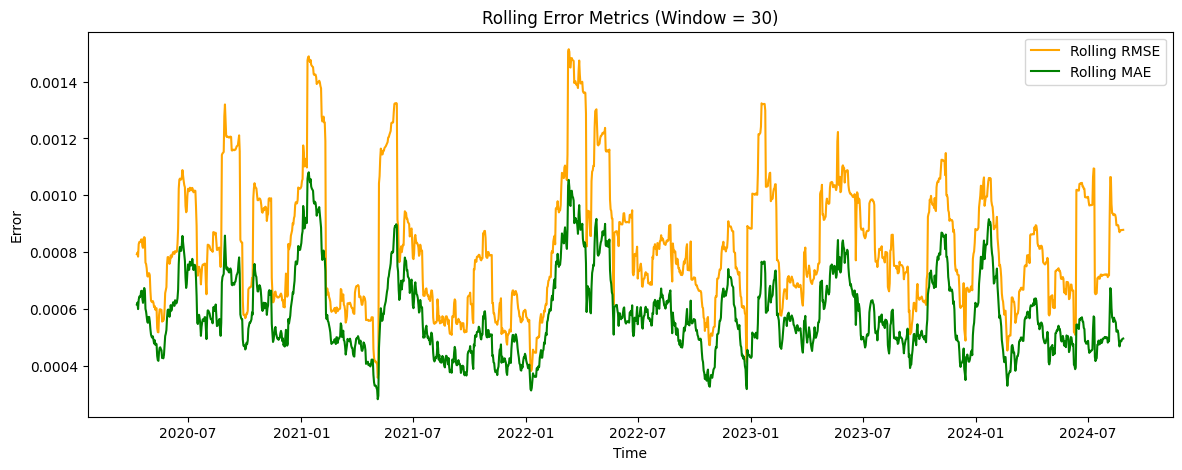

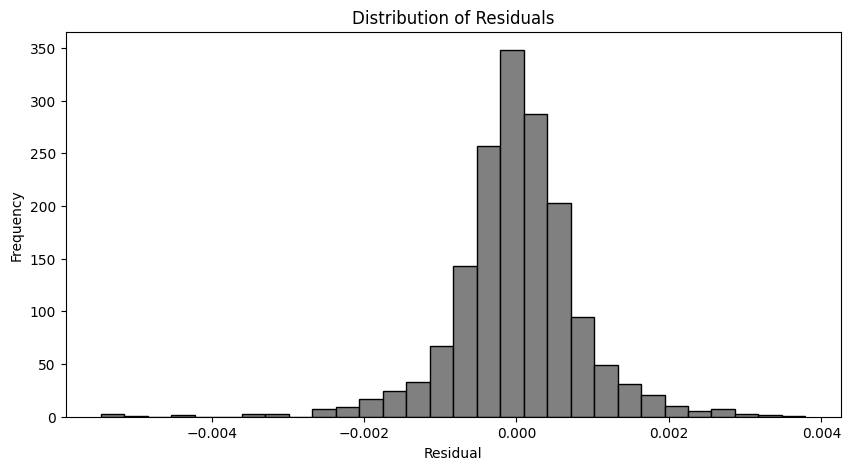

C:\Users\Student\AppData\Local\Temp\ipykernel_133132\1785558640.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')


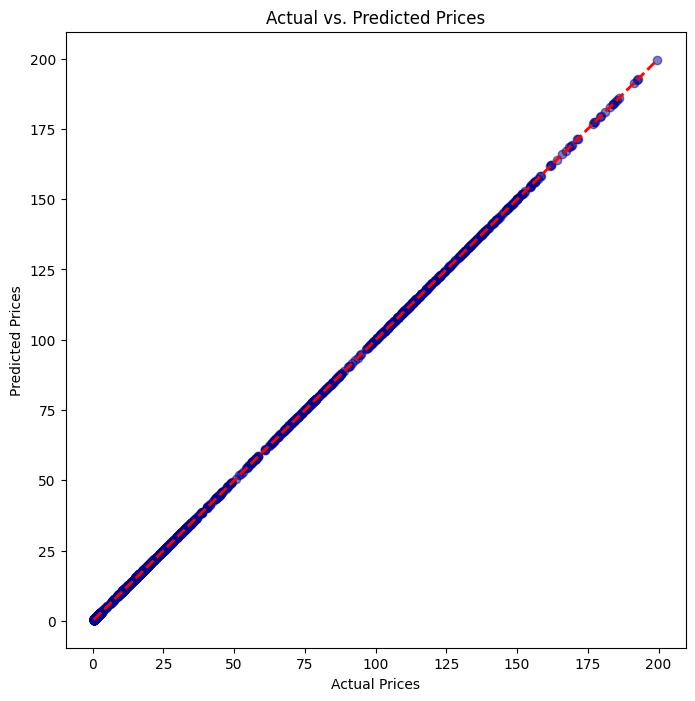

In [38]:

# Visualization Section

# 1. Predictions vs. Actuals Line Plot
plt.figure(figsize=(14, 5))
plt.plot(data.index, y, color='blue', label='Actual Solana Prices')
plt.plot(data.index, y_pred, color='red', label='Predicted Solana Prices by XGBoost')
plt.title('Solana Price Prediction using XGBoost')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# 2. Residual Plot
# Calculate residuals
residuals = y - y_pred

plt.figure(figsize=(14, 5))
plt.plot(data.index, residuals, color='purple', label='Residuals (Actual - Predicted)')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

# 3. Rolling RMSE or MAE Plot
# Define window size (e.g., 30 days)
rolling_window = 30

# Calculate rolling RMSE
rolling_rmse = pd.Series((y - y_pred) ** 2).rolling(window=rolling_window).mean().apply(np.sqrt)
rolling_mae = pd.Series(np.abs(y - y_pred)).rolling(window=rolling_window).mean()

plt.figure(figsize=(14, 5))
plt.plot(data.index, rolling_rmse, color='orange', label='Rolling RMSE')
plt.plot(data.index, rolling_mae, color='green', label='Rolling MAE')
plt.title(f'Rolling Error Metrics (Window = {rolling_window})')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()

# 4. Error Distribution (Histogram)
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color='grey', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# 5. Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, color='darkblue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()
